In [0]:
import string
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing import text 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Embedding,
    LSTM, LSTMCell, Dense, Flatten, Dropout)
from tensorflow.keras.activations import sigmoid, tanh, relu, softmax
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds

%matplotlib inline

In [0]:
imdb, info = tfds.load('imdb_reviews', with_info=True)
train, test = imdb['train'], imdb['test']

In [0]:
train_text = train.map(lambda x: x['text'])
test_text = test.map(lambda x: x['text'])

train_labels = train.map(lambda x: x['label'])
test_labels = test.map(lambda x: x['label'])

CPU times: user 17.9 s, sys: 5.95 s, total: 23.9 s
Wall time: 15.7 s


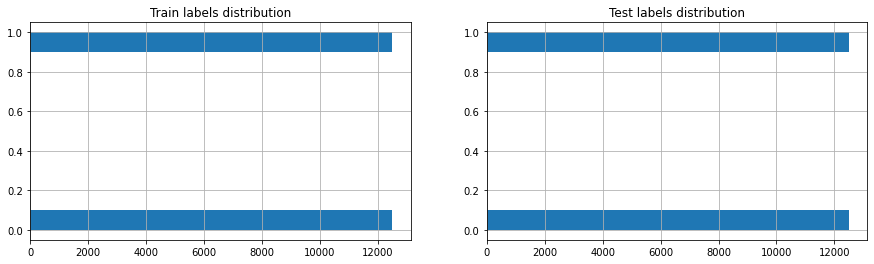

In [5]:
%%time
trainlabs_np = np.array(list(map(lambda x: x.numpy(), train_labels)))
testlabs_np = np.array(list(map(lambda x: x.numpy(), test_labels)))

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].hist(trainlabs_np, orientation='horizontal')
ax[0].set_title('Train labels distribution')
ax[0].grid()
ax[1].hist(testlabs_np, orientation='horizontal')
ax[1].set_title('Test labels distribution')
ax[1].grid()

In [6]:
def get_numexamples(data: tfds.core.DatasetInfo, key: str) -> int:
    return data.splits[key].num_examples

lengths = [get_numexamples(info, key)
           for key in ['train', 'test']] 

print(f'Train, test lengths: {lengths}')

Train, test lengths: [25000, 25000]


In [7]:
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
punc_signs = string.punctuation
punc_signs

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
nltk.download('punkt')

# Extract lower byte string from tensor in certain encoding
def bytes_to_raw(data: tf.Tensor) -> str:
    return data.numpy().decode('utf8').lower()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
%%time
train_text = list(map(bytes_to_raw, train_text))
test_text = list(map(bytes_to_raw, test_text))

CPU times: user 18 s, sys: 5.82 s, total: 23.8 s
Wall time: 14.5 s


In [10]:
%%time
import re
import itertools

# Find separate numeric values in corpus
train_nums = [re.findall(r'\d+', text) for text in train_text]
train_nums = set(itertools.chain(*train_nums))
test_nums = [re.findall(r'\d+', text) for text in test_text]
test_nums = set(itertools.chain(*test_nums))
nums = train_nums | test_nums

print(f'Count of numerics: {len(nums)}')

Count of numerics: 863
CPU times: user 1.46 s, sys: 0 ns, total: 1.46 s
Wall time: 1.46 s


In [11]:
%%time
## Break text into tokens - separate words and signs
train_tokenized = [nltk.word_tokenize(text) for text in train_text]
test_tokenized = [nltk.word_tokenize(text) for text in test_text]

CPU times: user 1min 33s, sys: 373 ms, total: 1min 33s
Wall time: 1min 33s


In [12]:
%%time
extra_stop = ["''", "...", "``", "--", "'s", "br"]
all_stops = stopwords + extra_stop

# Clean text from stops and numbers
train_tokens = list([
    word for word in words
    if (word not in punc_signs) and (word not in all_stops)
    and (word not in nums)
] for words in train_tokenized)

test_tokens = list([
    word for word in words
    if (word not in punc_signs) and (word not in all_stops)
    and (word not in nums)
] for words in test_tokenized)

CPU times: user 19.3 s, sys: 15.3 ms, total: 19.3 s
Wall time: 19.3 s


In [0]:
# I choosed not to use spacy lemmatization 'cause of it's very low speed

In [14]:
%%time
nltk.download('wordnet')

# Tokens lemmatization
lemmatizer = WordNetLemmatizer()

train_tokens = list([
    lemmatizer.lemmatize(word, pos='v') for word in words
] for words in train_tokens)

test_tokens = list([
    lemmatizer.lemmatize(word, pos='v') for word in words
] for words in test_tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
CPU times: user 27.6 s, sys: 145 ms, total: 27.7 s
Wall time: 28 s


In [15]:
%%time
flatten_train = list(itertools.chain(*train_tokens))
print(f'Count of tokens in train corpus: {len(flatten_train)}')
flatten_test = list(itertools.chain(*test_tokens))
print(f'Count of tokens in test corpus: {len(flatten_test)}')

vocab_size = len(set(flatten_train) | set(flatten_test))
print(f'Vocabulary size: {vocab_size}')

Count of tokens in train corpus: 3029167
Count of tokens in test corpus: 2960123
Vocabulary size: 154879
CPU times: user 720 ms, sys: 39.9 ms, total: 760 ms
Wall time: 760 ms


In [0]:
# 1 TfIdf + LogReg протестить
# 2 Tokenizer + Dense network протестить
# 3 Обучить небольшой эмбеддинг и рнн на керасе и протестить
# 5 Построить графики обучения
# 6 Посчитать для всех моделей точность, precision, recall
# 7 Сравнить модели, сделать выводы

#### 1) TfIdf + LogReg


In [17]:
# Define vectorizer with 1/20 count of important words
features_count = vocab_size // 20
tfidf_vector = TfidfVectorizer(max_features=features_count)
print('Count of word features: {}'.format(features_count))

Count of word features: 7743


In [0]:
# Build texts with initial content
# (without order, stopwords, lemmatized and lowered)
train_strs = [' '.join(words) for words in train_tokens]
test_strs = [' '.join(words) for words in test_tokens]

In [0]:
# Use tfidf-vect to get tf-idf text representation
train_vectors = tfidf_vector.fit_transform(train_strs)
test_vectors = tfidf_vector.transform(test_strs)

In [20]:
%%time
from sklearn.model_selection import train_test_split

log_reg = LogisticRegression(random_state=1, n_jobs=2)

# Train-val split
x_train, x_val, y_train, y_val = train_test_split(
    train_vectors, trainlabs_np, train_size=0.8, 
    random_state=0, shuffle=True
)

log_reg = log_reg.fit(x_train, y_train)

CPU times: user 47.3 ms, sys: 115 ms, total: 163 ms
Wall time: 1.39 s


In [0]:
def get_classification_metrics(labels, predicted, set_type: str):
    acc = accuracy_score(labels, predicted)
    prec = precision_score(labels, predicted)
    rec = recall_score(labels, predicted)

    print(f'{set_type} accuracy: {acc:.4f}\n'
          f'precision: {prec:.4f}\n'
          f'recall {rec:.4f}')

In [22]:
y_train_pred = log_reg.predict(x_train)
get_classification_metrics(y_train, y_train_pred, 'Train')

Train accuracy: 0.9241
precision: 0.9151
recall 0.9353


In [23]:
y_val_pred = log_reg.predict(x_val)
get_classification_metrics(y_val, y_val_pred, 'Validation')

Validation accuracy: 0.8806
precision: 0.8652
recall 0.8991


In [24]:
y_test_pred = log_reg.predict(test_vectors)
get_classification_metrics(testlabs_np, y_test_pred, 'Test')

Test accuracy: 0.8783
precision: 0.8766
recall 0.8805


#### Tokenizer + Dense network

In [0]:
# Define tokenizer with count of important words
# equals to 1/10 part of full vocabulary
tokenizer = text.Tokenizer(num_words=features_count)

In [0]:
tokenizer.fit_on_texts(train_strs)
dictionary = tokenizer.word_index

def text_to_indices(text_):
    return [dictionary[word] for word in text.text_to_word_sequence(text_)]

In [0]:
train_indices = [text_to_indices(text) for text in train_strs]
train_indices = np.asarray(train_indices)

x_train = tokenizer.sequences_to_matrix(train_indices, mode='binary')

In [0]:
y_train = to_categorical(trainlabs_np, 2)
y_test = to_categorical(testlabs_np, 2)

In [0]:
class ReviewClassifierNN(Model):
    def __init__(self):
        super(ReviewClassifierNN, self).__init__()
        self.fc1 = Dense(64, input_shape=(features_count,),
                         activation=relu)
        self.drop1 = Dropout(0.5)
        self.fc2 = Dense(256, activation=sigmoid)
        self.drop2 = Dropout(0.5)
        self.fc3 = Dense(64, activation=sigmoid)
        self.drop3 = Dropout(0.5)
        self.fc4 = Dense(2, activation=sigmoid)

    def call(self, x):
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.fc3(x)
        x = self.drop3(x)
        x = self.fc4(x)
        return x

In [0]:
model = ReviewClassifierNN()

optim = Adam(0.002)
bce = BinaryCrossentropy(from_logits=True)
model.compile(loss=bce, optimizer=optim,
              metrics=[BinaryAccuracy()])

In [31]:
batch_size_ = 512
epochs_ = 3
val_split = 0.2

history = model.fit(x_train, y_train,
                    batch_size=batch_size_, epochs=epochs_,
                    validation_split=val_split, shuffle=True)

Epoch 1/3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



40/40 [==============================] - 1s 33ms/step - loss: 0.6972 - binary_accuracy: 0.4995 - val_loss: 0.6831 - val_binary_accuracy: 0.5000
Epoch 2/3
40/40 [==============================] - 1s 23ms/step - loss: 0.6179 - binary_accuracy: 0.7226 - val_loss: 0.5657 - val_binary_accuracy: 0.8821
Epoch 3/3
40/40 [==============================] - 1s 23ms/step - loss: 0.5552 - binary_accuracy: 0.9049 - val_loss: 0.5620 - val_binary_accuracy: 0.8800


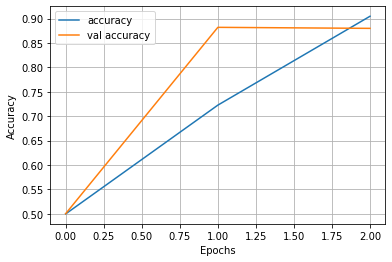

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val accuracy'])
plt.grid()

In [0]:
# Transform test texts into indices according to fitted dictionary
# absent words in dictionary are ignored
def input_to_indices(text_):
    return [dictionary[word] for word in text.text_to_word_sequence(text_)
            if word in dictionary]

In [0]:
test_indices = [input_to_indices(text) for text in test_strs]
test_indices = np.asarray(test_indices)

x_test = tokenizer.sequences_to_matrix(test_indices, mode='binary')

In [0]:
y_pred = model.predict(x_test)

In [0]:
# Convert from probabilities to most probable lable
y_pred = list(map(np.argmax, y_pred))

In [37]:
test_loss, test_acc = model.evaluate(x_test, y_test)
test_acc = accuracy_score(testlabs_np, y_pred)
test_prec = precision_score(testlabs_np, y_pred)
test_rec = recall_score(testlabs_np, y_pred)

782/782 [==============================] - 3s 3ms/step - loss: 0.5636 - binary_accuracy: 0.8774


In [38]:
print(f'Test loss {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}\n'
      f'precision: {test_prec:.4f}\n'
      f'recall {test_rec:.4f}')

Test loss 0.5636
Test accuracy: 0.8784
precision: 0.8583
recall 0.9066


#### Embedding + LSTM network

In [0]:
class LSTMClassifierNN(Model):
    def __init__(self):
        super(LSTMClassifierNN, self).__init__()
        self.embed = Embedding(2**8, 3)
        self.lstm = LSTM(3)
        self.fc = Dense(2, activation=sigmoid)

    def call(self, x):
        x = self.embed(x)
        x = self.lstm(x)
        x = self.fc(x)
        return x

In [0]:
lstm = LSTMClassifierNN()

lstm.compile(loss=bce, optimizer=optim,
             metrics=['accuracy'])

In [41]:
batch_size_ = 512
epochs_ = 5
val_split = 0.1

history = lstm.fit(x_train, y_train,
                   batch_size=batch_size_, epochs=epochs_,
                   validation_split=val_split, shuffle=True)

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



44/44 [==============================] - 29s 667ms/step - loss: 0.7180 - accuracy: 0.4997 - val_loss: 0.7085 - val_accuracy: 0.5024
Epoch 2/5
44/44 [==============================] - 29s 650ms/step - loss: 0.7034 - accuracy: 0.4997 - val_loss: 0.6995 - val_accuracy: 0.5024
Epoch 3/5
44/44 [==============================] - 29s 652ms/step - loss: 0.6978 - accuracy: 0.4997 - val_loss: 0.6963 - val_accuracy: 0.5024
Epoch 4/5
44/44 [==============================] - 29s 654ms/step - loss: 0.6957 - accuracy: 0.4997 - val_loss: 0.6951 - val_accuracy: 0.5024
Epoch 5/5
44/44 [==============================] - 29s 649ms/step - loss: 0.6949 - accuracy: 0.4997 - val_loss: 0.6945 - val_accuracy: 0.5024


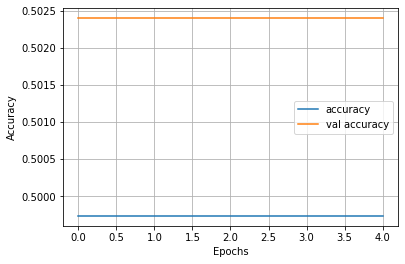

In [43]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val accuracy'])
plt.grid()

In [0]:
y_pred = lstm.predict(x_test)

In [0]:
y_pred = list(map(np.argmax, y_pred))

In [52]:
test_loss, test_acc = lstm.evaluate(x_test, y_test)
test_acc = accuracy_score(testlabs_np, y_pred)
test_prec = precision_score(testlabs_np, y_pred)
test_rec = recall_score(testlabs_np, y_pred)

print(f'Test loss {test_loss}')

782/782 [==============================] - 216s 277ms/step - loss: 0.6946 - accuracy: 0.5000
Test loss 0.6945719718933105


In [49]:
print(f'Test accuracy: {test_acc:.4f}\n'
      f'precision: {test_prec:.4f}\n'
      f'recall {test_rec:.4f}')

Test accuracy: 0.5000
precision: 0.5000
recall 1.0000


#### Conclusions


For plain text classification tasks such imdb reviews ML model usage is enough
to achieve great predictive strength.
Above example of logistic regression demonstrated high-valued metrics on all datasets: about of 87, 88 and 92 % respectively on test, val and train.

Metrics for dense network model after tokenization are near to LogReg results, but this model requires more training data with more time as expected.

LSTM presented very bad results during training as during prediction.
In addition this model consumed much more time to be fitted.
It was very strange to me.